In [164]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from torch import nn
import torch
import albumentations as A
from src import config
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader

%matplotlib inline


375 499


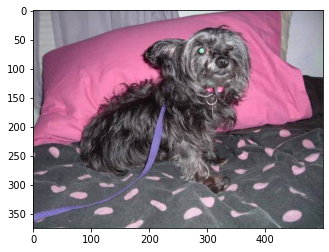

In [2]:
dog = Image.open("data/train/dog.0.jpg")
print(dog.height, dog.width)
plt.imshow(dog)


In [3]:
dog_array = np.array(dog)
dog_array.shape


(375, 499, 3)

374 500


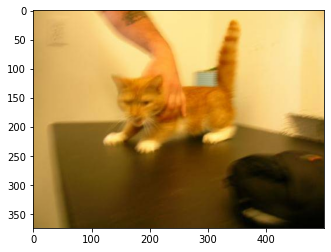

In [4]:
cat = Image.open("data/train/cat.0.jpg")
print(cat.height, cat.width)
plt.imshow(cat)


In [5]:
cat_array = np.array(cat)
cat_array.shape


(374, 500, 3)

In [155]:
from __future__ import annotations

class CatsDogsDataset(Dataset):
    def __init__(self, csv, transform=None, resize: tuple[int, int] = None):
        self.df: pd.DataFrame = pd.read_csv(csv)
        self.transform = transform
        self.resize = resize

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx) -> dict[str, torch.Tensor | int]:
        # Load image path and label
        img = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]

        # Read image
        img = Image.open(img).convert("RGB")

        # Resize if required
        if self.resize is not None:
            width, height = reversed(self.resize)
            img = img.resize((width, height), resample=Image.BILINEAR)

        # Convert to NumPy array
        img = np.array(img)

        # Apply transformations
        if self.transform is not None:
            img = self.transform(image=img)["image"]

        # Move the channels axis to the front
        img = np.transpose(img, axes=(-1, 0, 1)).astype(np.float32)
        img = torch.tensor(img)

        return {"image": img, "label": torch.tensor(label, dtype=torch.float32)}


In [170]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.4),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(always_apply=True),
    ]
)
dataset = CatsDogsDataset(
    "data/train_data.csv",
    transform=transform,
    resize=(config.IMG_HEIGHT, config.IMG_WIDTH),
)
print(dataset.df["label"].value_counts())


0    12500
1    12500
Name: label, dtype: int64


In [157]:
idx = 24999
sample = dataset[idx]
image, label = sample.values()
image.shape, label


(torch.Size([3, 200, 200]), tensor(1.))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


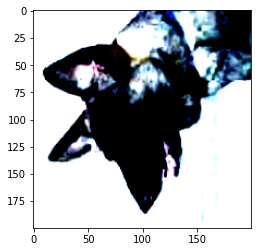

In [158]:
plt.imshow(torch.swapaxes(image, 0, -1))


In [211]:
class CatsDogsModel(nn.Module):
    def __init__(self):
        super().__init__()
        

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5, 5))
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.dropout = nn.Dropout(p=0.3)

        self.linear1 = nn.Linear(64 * 9 * 9, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)


    def forward(self, x, label=None):
        x = nn.ReLU()(self.conv1(x))
        x = self.maxpool1(x)
        x = nn.ReLU()(self.conv2(x))
        x = self.maxpool2(x)
        x = nn.ReLU()(self.conv3(x))
        x = self.maxpool3(x)
        x = nn.ReLU()(self.conv4(x))
        x = self.maxpool4(x)

        x = self.dropout(nn.Flatten()(x))
        
        x = nn.ReLU()(self.linear1(x))
        x = nn.ReLU()(self.linear2(x))
        x = nn.ReLU()(self.linear3(x))
        x = nn.Sigmoid()(self.out(x))

        return x



In [217]:
model = CatsDogsModel()
num_samples = len(dataset)
val_size = int(0.1 * num_samples)
training_set, validation_set = torch.utils.data.random_split(dataset, [num_samples - val_size, val_size])
training_set = DataLoader(training_set, batch_size=config.BATCH_SIZE, shuffle=True)

In [218]:
for idx, batch in enumerate(training_set):
    print(batch["image"].shape)
    x = model(batch["image"])
    break

print(x)

torch.Size([64, 3, 200, 200])
tensor([[0.4791],
        [0.4791],
        [0.4789],
        [0.4788],
        [0.4798],
        [0.4793],
        [0.4795],
        [0.4793],
        [0.4794],
        [0.4792],
        [0.4798],
        [0.4792],
        [0.4798],
        [0.4792],
        [0.4795],
        [0.4792],
        [0.4785],
        [0.4795],
        [0.4800],
        [0.4790],
        [0.4801],
        [0.4799],
        [0.4791],
        [0.4796],
        [0.4790],
        [0.4795],
        [0.4793],
        [0.4792],
        [0.4797],
        [0.4797],
        [0.4796],
        [0.4794],
        [0.4792],
        [0.4795],
        [0.4796],
        [0.4785],
        [0.4794],
        [0.4795],
        [0.4789],
        [0.4793],
        [0.4794],
        [0.4789],
        [0.4795],
        [0.4795],
        [0.4797],
        [0.4792],
        [0.4791],
        [0.4795],
        [0.4798],
        [0.4793],
        [0.4799],
        [0.4795],
        [0.4791],
        [0.4795]

In [214]:
x.shape

torch.Size([64, 1])